In [1]:
!gpustat

blade                Mon Jul 12 12:00:18 2021  455.45.01
[0] RTX A6000        | 84'C,  98 % | 44898 / 48685 MB | wangh19(44895M)
[1] RTX A6000        | 80'C,  94 % | 44886 / 48685 MB | wangh19(44883M)
[2] RTX A6000        | 38'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 30'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 28'C,   0 % |     1 / 48685 MB |
[7] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
path = '2d_toy/'

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [6]:
from helpers import *

In [7]:
class sampler:
    def __init__(self, X, Y, batch_size):

        self.X = X
        self.Y = Y
        self.batch_size = batch_size
    @partial(jit, static_argnums=(0,))
    def sample(self, key):
        idx = random.choice(key, np.arange(self.X.shape[0]), shape = (batch_size,), replace = False)
        return (self.X[idx], self.Y[idx])

In [8]:
key = random.PRNGKey(int(time.time()*100))

In [9]:
target_fn = lambda X: 2 * np.sin(8 * np.pi * X[:,0])*np.cos(24 * np.pi * X[:,1]) + np.sin(16 * np.pi * X[:,0])*np.cos(12 * np.pi * X[:,1])

In [10]:
X = random.uniform(key, shape = (2**12, 2), minval = -1, maxval = 1)
Y = target_fn(X)
Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.01
mu_X, sigma_X = X.mean(0), X.std(0)
X = (X - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

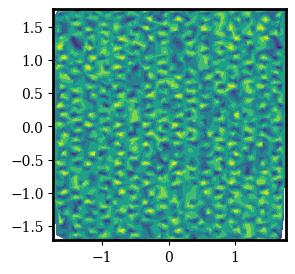

In [11]:
plt.figure(figsize = (3,3))
plt.tricontourf(X[:,0], X[:,1], Y)
plt.axis('equal')
plt.show()
plt.close()

In [12]:
X_test = np.array(np.meshgrid(np.linspace(-1,1,200), np.linspace(-1,1,200))).transpose((1,2,0)).reshape(-1,2)
Y_test = target_fn(X_test)

X_test = (X_test - mu_X) / sigma_X
Y_test = (Y_test - mu_Y) / sigma_Y

In [13]:
batch_size = 1024
data_sampler = sampler(X, Y, batch_size)

In [14]:
depth = [4, 8, 16, 32]
normal_init = []
scaled_init = []

for d in depth:

    layers = [X.shape[1], *[256 for _ in range(int(d))], 1]
    activation = np.tanh
    fit_model = MLPRegression(layers, activation = activation)

    init_model = initNet(layers[:-1], activation = activation)

    lr = 5e-3
    init_fn, update_fn, get_params = optimizers.adam(lr)
    # init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
    lam = 1e-4
    @jit
    def step(i, state, X):
        key = random.PRNGKey(i)
        g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
        return update_fn(i, g, state)
    print(f'Important: confirm lam {lam} before running!!!!!!!!!!!!!!!')

    opt_state = init_fn(init_model.scale_params)
    init_nIter = 10000
    pbar = trange(init_nIter)
#     scale_stor = []
#     bias_stor = []

    for i in pbar:
        mini_batch = data_sampler.sample(random.PRNGKey(i))[0]
        opt_state = step(i, opt_state, mini_batch)

#         if i % 100 == 0:
#             params = get_params(opt_state)
#             pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), mini_batch)})
#             scale_stor.append([w for (w, b) in params])
#             bias_stor.append([b for (w, b) in params])


#     scale_stor = np.array(scale_stor)
#     bias_stor = np.array(bias_stor)]
    
    scale_params = get_params(opt_state)

    fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

    scaled_init.append(fit_model.net_apply(fit_model.scaled_net_params, X_test).flatten())
    normal_init.append(fit_model.net_apply(fit_model.net_params, X_test).flatten())

  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


100%|██████████| 10000/10000 [00:51<00:00, 194.68it/s]


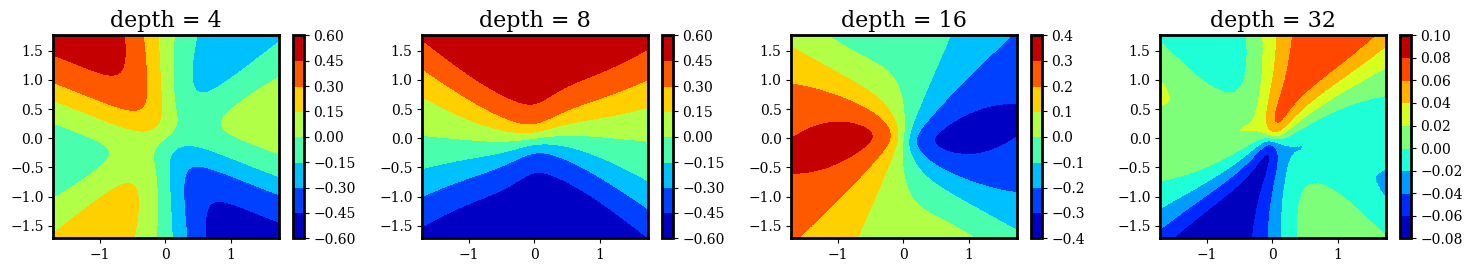

In [15]:
plt.figure(figsize = (15,3))
for j, pred in enumerate(normal_init):
    plt.subplot(1,4,j + 1)
    plt.tricontourf(X_test[:,0], X_test[:,1], pred, cmap = 'jet')
    plt.colorbar()
    plt.title(f'depth = {int(depth[j])}')
    plt.tight_layout()

plt.savefig(path + 'normal_init_depth.pdf', dpi = 200)
plt.show()
plt.close()

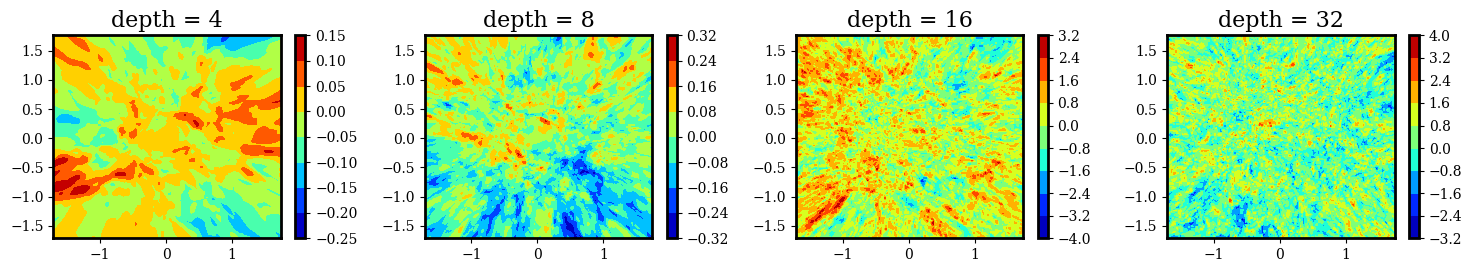

In [16]:
plt.figure(figsize = (15,3))
for j, pred in enumerate(scaled_init):
    plt.subplot(1,4,j + 1)
    plt.tricontourf(X_test[:,0], X_test[:,1], pred, cmap = 'jet')
    plt.colorbar()
    plt.title(f'depth = {int(depth[j])}')
    plt.tight_layout()

plt.savefig(path + 'scale_init_depth.pdf', dpi = 200)
plt.show()
plt.close()

In [17]:
lam = [1e-2, 1e-3, 1e-4, 1e-5]
normal_init_lam = []
scaled_init_lam = []

for l in lam:

    layers = [X.shape[1], *[256 for _ in range(16)], 1]
    activation = np.tanh
    fit_model = MLPRegression(layers, activation = activation)

    init_model = initNet(layers[:-1], activation = activation)

    lr = 5e-3
    init_fn, update_fn, get_params = optimizers.adam(lr)
    # init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
    print(f'Important: confirm lam {l} before running!!!!!!!!!!!!!!!')
    @jit
    def step(i, state, X):
        key = random.PRNGKey(i)
        g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = l)
        return update_fn(i, g, state)
   

    opt_state = init_fn(init_model.scale_params)
    init_nIter = 10000
    pbar = trange(init_nIter)
#     scale_stor = []
#     bias_stor = []

    for i in pbar:
        mini_batch = data_sampler.sample(random.PRNGKey(i))[0]
        opt_state = step(i, opt_state, mini_batch)

#         if i % 100 == 0:
#             params = get_params(opt_state)
#             pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), mini_batch)})
#             scale_stor.append([w for (w, b) in params])
#             bias_stor.append([b for (w, b) in params])


#     scale_stor = np.array(scale_stor)
#     bias_stor = np.array(bias_stor)]
    
    scale_params = get_params(opt_state)

    fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

    scaled_init_lam.append(fit_model.net_apply(fit_model.scaled_net_params, X_test).flatten())
    normal_init_lam.append(fit_model.net_apply(fit_model.net_params, X_test).flatten())

  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 0.01 before running!!!!!!!!!!!!!!!


  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 0.001 before running!!!!!!!!!!!!!!!


  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


  0%|          | 0/10000 [00:00<?, ?it/s]

Important: confirm lam 1e-05 before running!!!!!!!!!!!!!!!


100%|██████████| 10000/10000 [00:31<00:00, 318.95it/s]


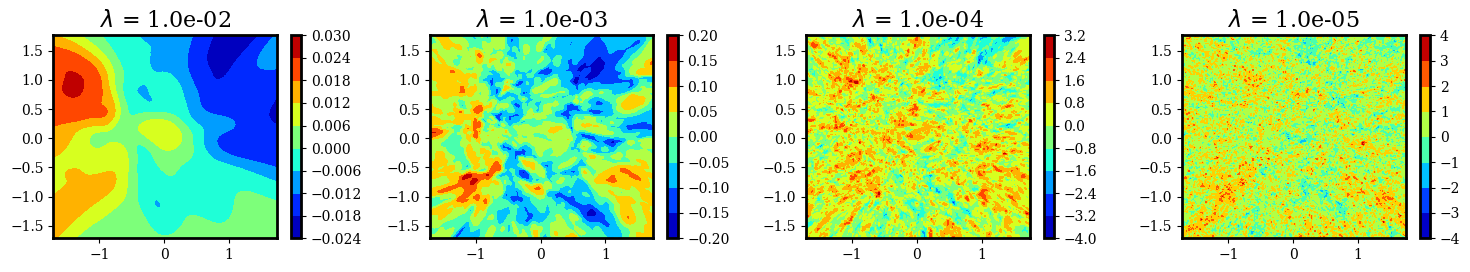

In [18]:
plt.figure(figsize = (15,3))
for j, pred in enumerate(scaled_init_lam):
    plt.subplot(1,4,j + 1)
    plt.tricontourf(X_test[:,0], X_test[:,1], pred, cmap = 'jet')
    plt.colorbar()
    plt.title(r'$\lambda$' + f' = {lam[j]:.1e}')
    plt.tight_layout()

plt.savefig(path + 'init_lam.pdf', dpi = 200)
plt.show()
plt.close()